In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# The dateutil module is an extension to the datetime module. One advantage is that we don't need to 
# pass any parsing code to parse a string.
from dateutil.parser import parse

from pandas_profiling import ProfileReport
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans

# Importing different scalers:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from sklearn.neighbors import NearestNeighbors

from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

##### ========= Functions =========

In [2]:
def columns_to_filter(key, end, start = 1):
    """
    Creating list of keys to filter the columns of the dataframe
    """
    
    columns = []
    
    for n in range(start, end+1):
        columns.append( key + str(n) )
    
    return columns

In [3]:
def correlation(df, corr_type, threshold ):
    """
    To check correlations
    """
    
    # Prepare figure
    fig = plt.figure(figsize=(20, 15))

    # Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
    corr = np.round(df.corr(method = corr_type), decimals=2)

    # Build annotation matrix (values above |threshold| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= threshold
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    #fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    plt.show()

In [4]:
def hist_box_plotting( df , hist = True):
    """
    To explore metric variables using hist and boxplot 
    """
    
    columns = df.columns.to_list()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots( ceil(len(columns) / 2), 2, figsize=(20, 50) )

    # Plot data
    if hist:
        for ax, feat in zip(axes.flatten(), columns):
            ax.hist(df[feat])
            ax.set_title(feat)
    else:
        for ax, feat in zip(axes.flatten(), columns):
            sns.boxplot(x=df[feat], ax=ax)
            ax.set_title(feat)

    plt.show()

In [5]:
def inertia_plot(df, max_clusters = 10):
    inertia = []
    for n_clus in range(1, max_clusters):  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters = n_clus, 
                         init='k-means++', 
                         n_init=15, 
                         random_state=73)

        kmclust.fit(df)
        inertia.append(kmclust.inertia_)  # save the inertia

    plt.figure(figsize=(8,6))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()

In [6]:
def build_SOM(df, grid, rough_train, finetune):
    # This som implementation does not have a random seed parameter
    # We're going to set it up ourselves
    np.random.seed(42)

    sm = sompy.SOMFactory().build(
        df.values, 
        mapsize = grid,
        initialization='random', 
        neighborhood = 'gaussian',
        training='batch',
        lattice='hexa',
        component_names = df.columns.to_list()
    )
    
    sm.train(n_job=4, verbose='info', train_rough_len = rough_train, train_finetune_len = finetune)
    
    return sm

In [7]:
def SOM_component_planes(sm):
    # Visualizing the Component planes (feature values)
    sns.set()
    view2D = View2D(12,12,"", text_size=10)
    view2D.show(sm, col_sz=3, what='codebook')
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Component Planes", fontsize=20)
    plt.show()

In [8]:
def SOM_U_matrix(sm):

    # U-matrix of the 20x20 grid
    u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

    UMAT = u.show(
        sm, 
        distance2=1, 
        row_normalized=False, 
        show_data=False, 
        contooor=True # Visualize isomorphic curves
    )

In [9]:
def distance_graph(df, neighbors):

    # K-distance graph to find out the right eps value
    neigh = NearestNeighbors(n_neighbors = neighbors)
    neigh.fit(df)
    distances, _ = neigh.kneighbors(df)
    distances = np.sort(distances[:, -1])
    plt.plot(distances)
    plt.show()

In [10]:
def get_ss(df):
    """
    Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

##### ==================

Let's import our dataset:

In [11]:
df_fix = pd.read_csv('pre_processed_data.csv')

df_fix.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,0,0,1957-12-01,0,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,0,0,1972-02-01,0,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,0,0,1968-01-01,0,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,0,0,1948-01-01,0,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,MBC,0,FL,33176,0,0,1940-01-01,0,1,...,6.864865,7112,1,L,2,F,X,X,X,A


In the past workbook we slected the features described below to understand the neighborhood of the donors:

In [12]:
selected_percentage = ['POP90C1', 'POP90C2', 'POP90C3', 'ETH1', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC4', 'AGEC5', 'HHN3',\
                       'MARR1', 'MARR2','DW1', 'DW2', 'HU1', 'HHD3', 'HVP5', 'RP3', 'IC7', 'TPE1', 'TPE7', 'TPE10', 'OEDC5',\
                       'VC1', 'VC2']

len(selected_percentage)

26

Although we selected 26 features from 475 in our original dataset, 26 features is still a high number to do clustering by and derive some value from it.

Let's create sub categories of these variables using the PVA metadata file:

In [13]:
df_fix[selected_percentage].head()

,POP90C1,POP90C2,POP90C3,ETH1,AGE907,CHIL1,CHIL2,CHIL3,AGEC4,AGEC5,...,HHD3,HVP5,RP3,IC7,TPE1,TPE7,TPE10,OEDC5,VC1,VC2
0,0.0,35.0,65.0,92,25,31.0,42.0,27.0,17.171717,13.131313,...,70,47,17,23.232323,88,0,14,78,34,23
1,100.0,0.0,0.0,67,32,33.0,46.0,21.0,23.232323,10.101010,...,88,99,91,6.000000,80,0,24,69,55,10
2,0.0,2.0,98.0,96,23,35.0,40.0,25.0,16.161616,13.131313,...,65,50,9,18.000000,74,0,19,74,28,23
3,0.0,8.0,92.0,61,25,45.0,35.0,20.0,17.000000,12.000000,...,61,92,17,12.000000,58,0,13,87,14,40
4,100.0,0.0,0.0,2,27,34.0,43.0,23.0,15.000000,20.000000,...,49,67,74,29.292929,73,0,24,49,9,16


Let's check the histograms for each:

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSiz

findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Bold.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Euro Sign' (eurosign.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<

findfont: score(<Font 'Myriad Pro' (MyriadPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Gurmukhi' (AdobeGurmukhi-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 1

findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Medium.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Charlemagne Std' (CharlemagneStd-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Myriad Arabic' (MyriadArabic-It.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Minion Pro' (MinionPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
find

findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
findfont: score(<Font 'Gentium Book Basic' (GenBkBasR.ttf) normal normal book normal>) = 10.05
findfont: score(<Font 'Arimo' (Arimo-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
findfont: score(<Font 'Tekton Pro' (TektonPro-BoldCond.otf) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font

findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Nueva Std' (NuevaStd-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Heavy.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Source Sans Pro' (SourceSansPro-Semibold.otf) normal normal semibold normal>) = 10.24
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Informal Roman' (INFROMAN.TTF) normal normal roman normal>) = 10.145
findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Regular.otf) normal normal

findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335

findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Constantia' (constanb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal bold normal>) = 10.335
findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
findfont: score(<Font 'Tekton Pro' (TektonPro-BoldExt.otf) normal normal bold normal>) = 

findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 6.698636363636363
findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Medium.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal bold condensed>) = 0.5349999999999999
findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 6.888636363636364
findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Adobe Garamond Pro' (AGaramondPro-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 norm

findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal bold normal>) = 11.335
findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Light.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gentium Book Basic' (GenBkBasB.ttf) normal normal book normal>) = 10.05
findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trajan Pro 3' (TrajanPro3-Regular.otf) normal normal 400 normal>) = 10.05
findfont: sc

findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Source Sans Pro' (SourceSansPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 6.8986363636363635
findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Courier New' (courbi.ttf) italic normal bold normal>) = 11.335
findfont: score

findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Myriad Pro' (MyriadPro-Cond.otf) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
findfont: score(<Font 'Chaparral Pro' (ChaparralPro-BoldIt.otf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
findfont: score(<Font 'Kozuka Mincho Pr6N' (KozMinPr6N-Bold.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>

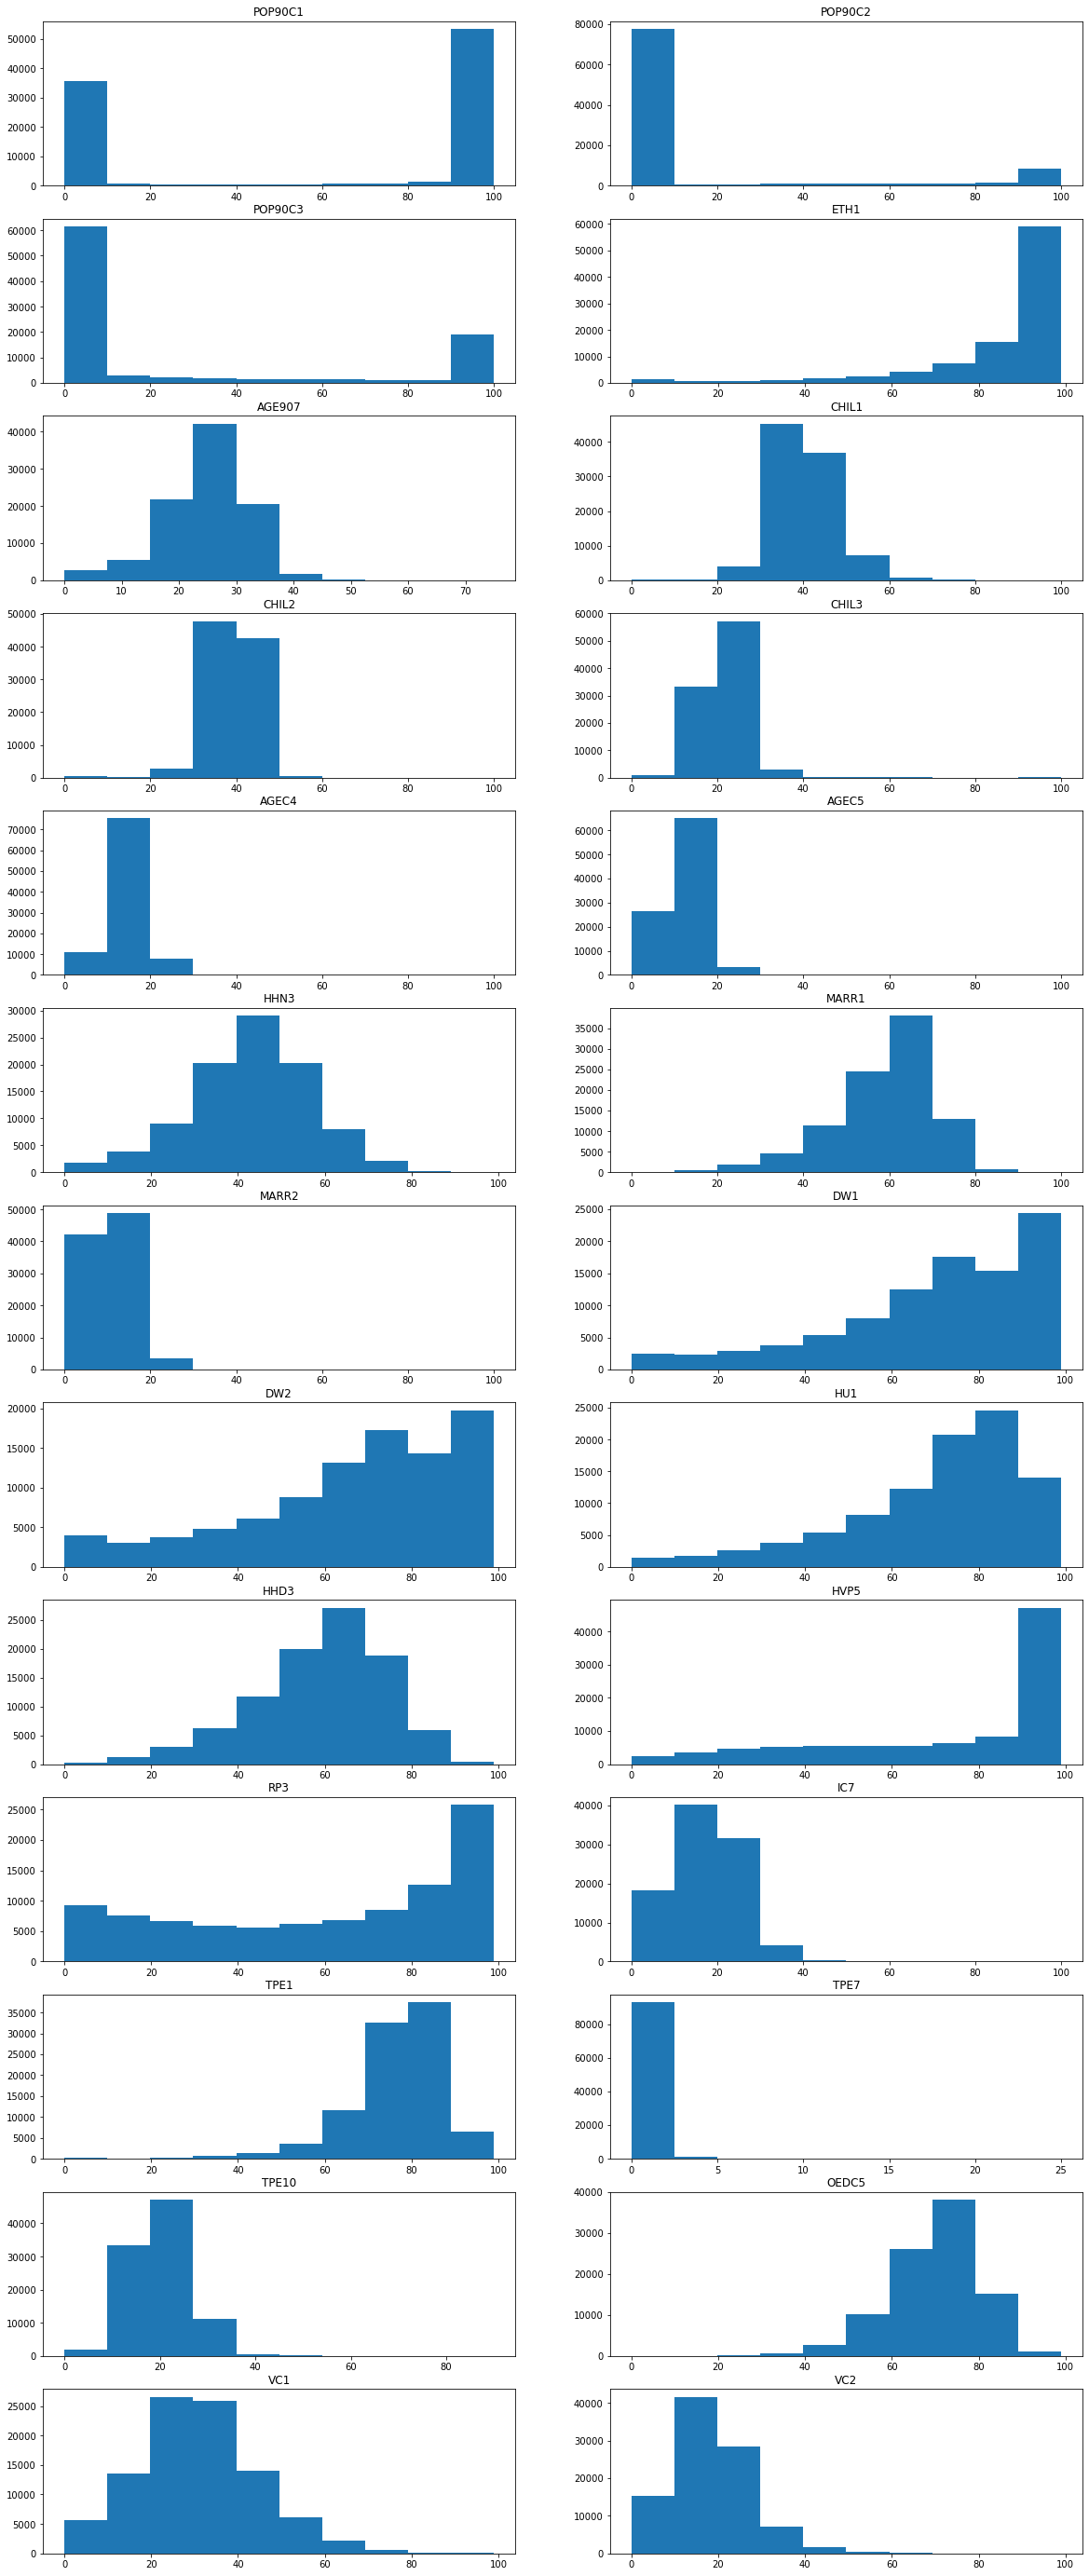

In [14]:
hist_box_plotting( df_fix[selected_percentage] )

Looking at the histograms above makes sense to drop the following features:

In [15]:
selected_percentage.remove('TPE7')
selected_percentage.remove('OEDC5')
selected_percentage.remove('MARR2')

NumExpr defaulting to 4 threads.
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E1249FC430>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E1249FC430>
Setting pcolormesh
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 4

findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-SemiboldItalic.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Bold.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Euro Sign' (eurosign.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
find

findfont: score(<Font 'Adobe Arabic' (AdobeArabic-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Myriad Pro' (MyriadPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Gurmukhi' (AdobeGurmukhi-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) =

findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Medium.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Charlemagne Std' (CharlemagneStd-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Myriad Arabic' (MyriadArabic-It.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Minion Pro' (MinionPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiaz.ttf) it

findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
findfont: score(<Font 'Gentium Book Basic' (GenBkBasR.ttf) normal normal book normal>) = 10.05
findfont: score(<Font 'Arimo' (Arimo-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
findfont: score(<Font 'Tekton Pro' (TektonPro-BoldCond.otf) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
findfont: score(

findfont: score(<Font 'Myriad Pro' (MyriadPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Nueva Std' (NuevaStd-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Heavy.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Source Sans Pro' (SourceSansPro-Semibold.otf) normal normal semibold normal>) = 10.24
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>)

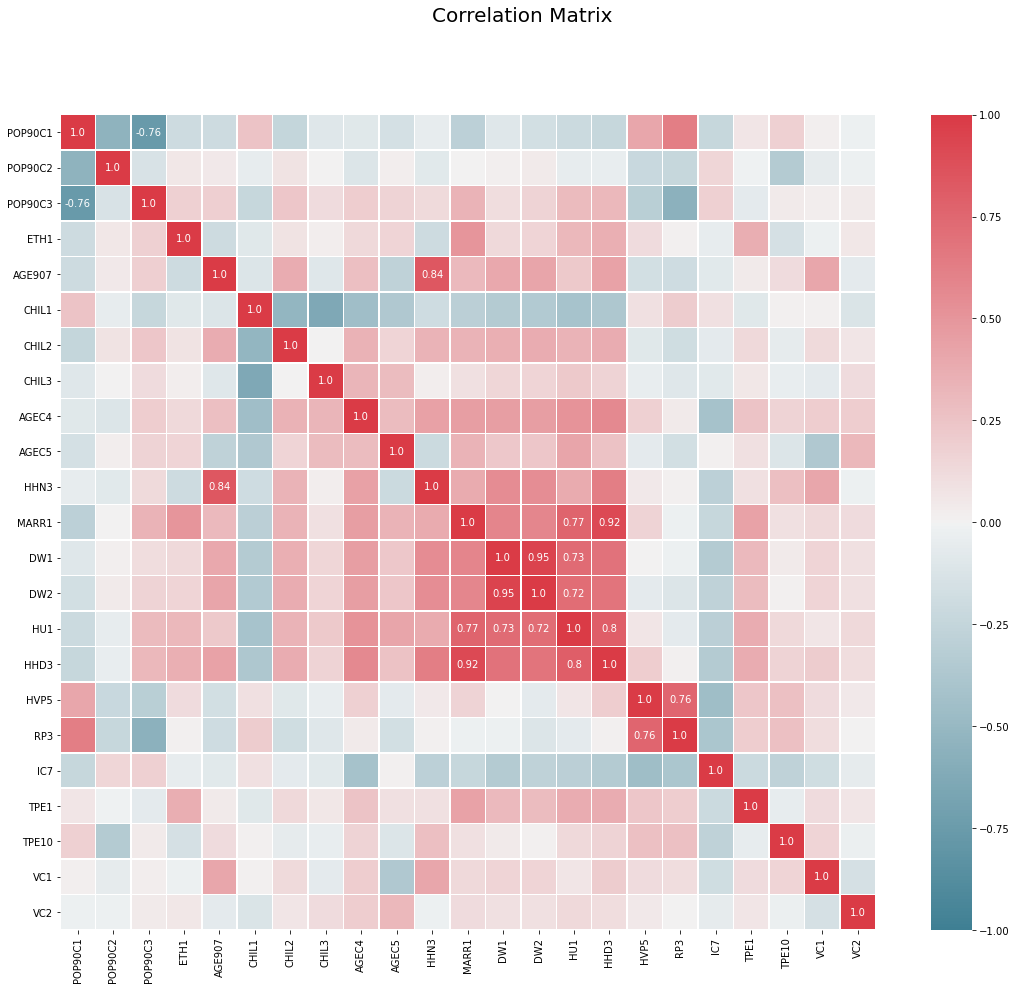

In [16]:
correlation(df_fix[selected_percentage], 'pearson', 0.7 )

We have some high correlations above. Let's drop those:

In [17]:
selected_percentage.remove('DW1')
selected_percentage.remove('DW2')
selected_percentage.remove('HU1')
selected_percentage.remove('HHD3')
selected_percentage.remove('RP3')
selected_percentage.remove('POP90C3')
selected_percentage.remove('HHN3')

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E124494460>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E124494460>
Setting pcolormesh


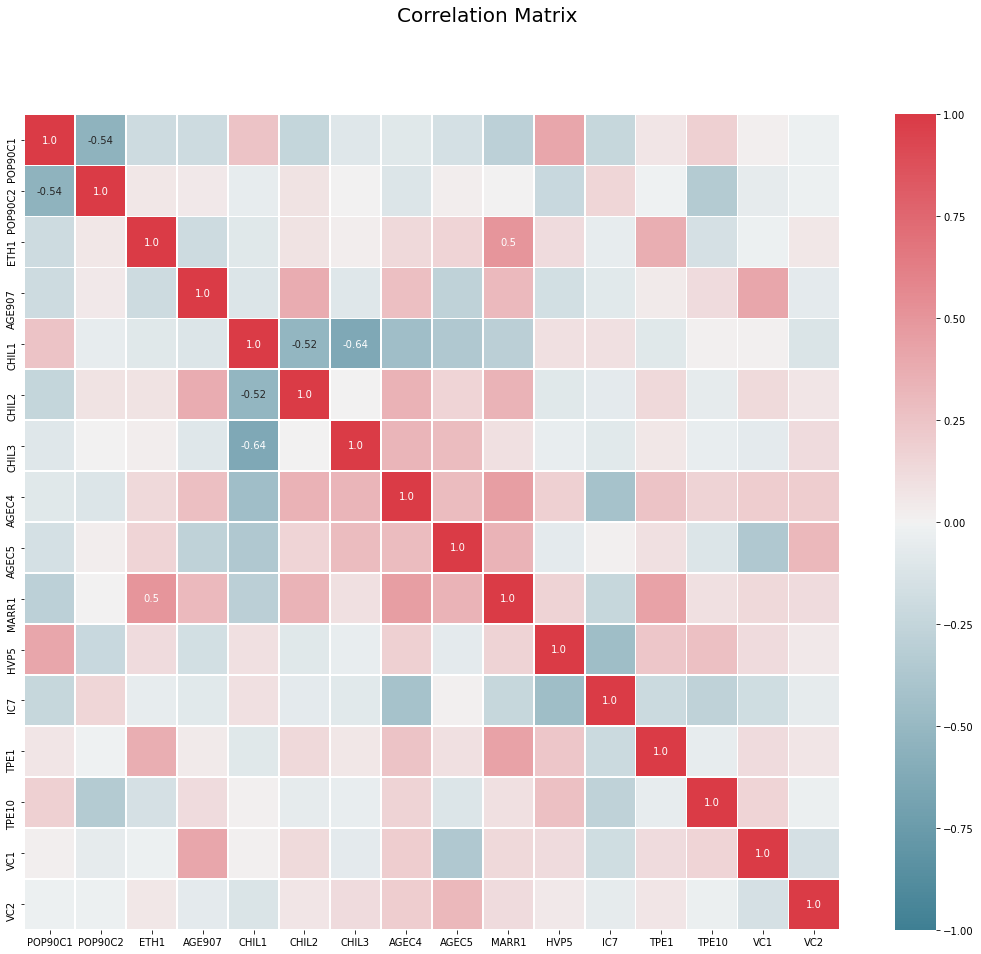

In [18]:
# Checking results:
correlation(df_fix[selected_percentage], 'pearson', 0.5 )

By looking at the metadata of the variables and the new range for the correlations. We will drop the following features:

In [19]:
selected_percentage.remove('POP90C2')
# The variable AGE907 holds information on underage people
selected_percentage.remove('CHIL1')
selected_percentage.remove('CHIL2')
selected_percentage.remove('CHIL3')

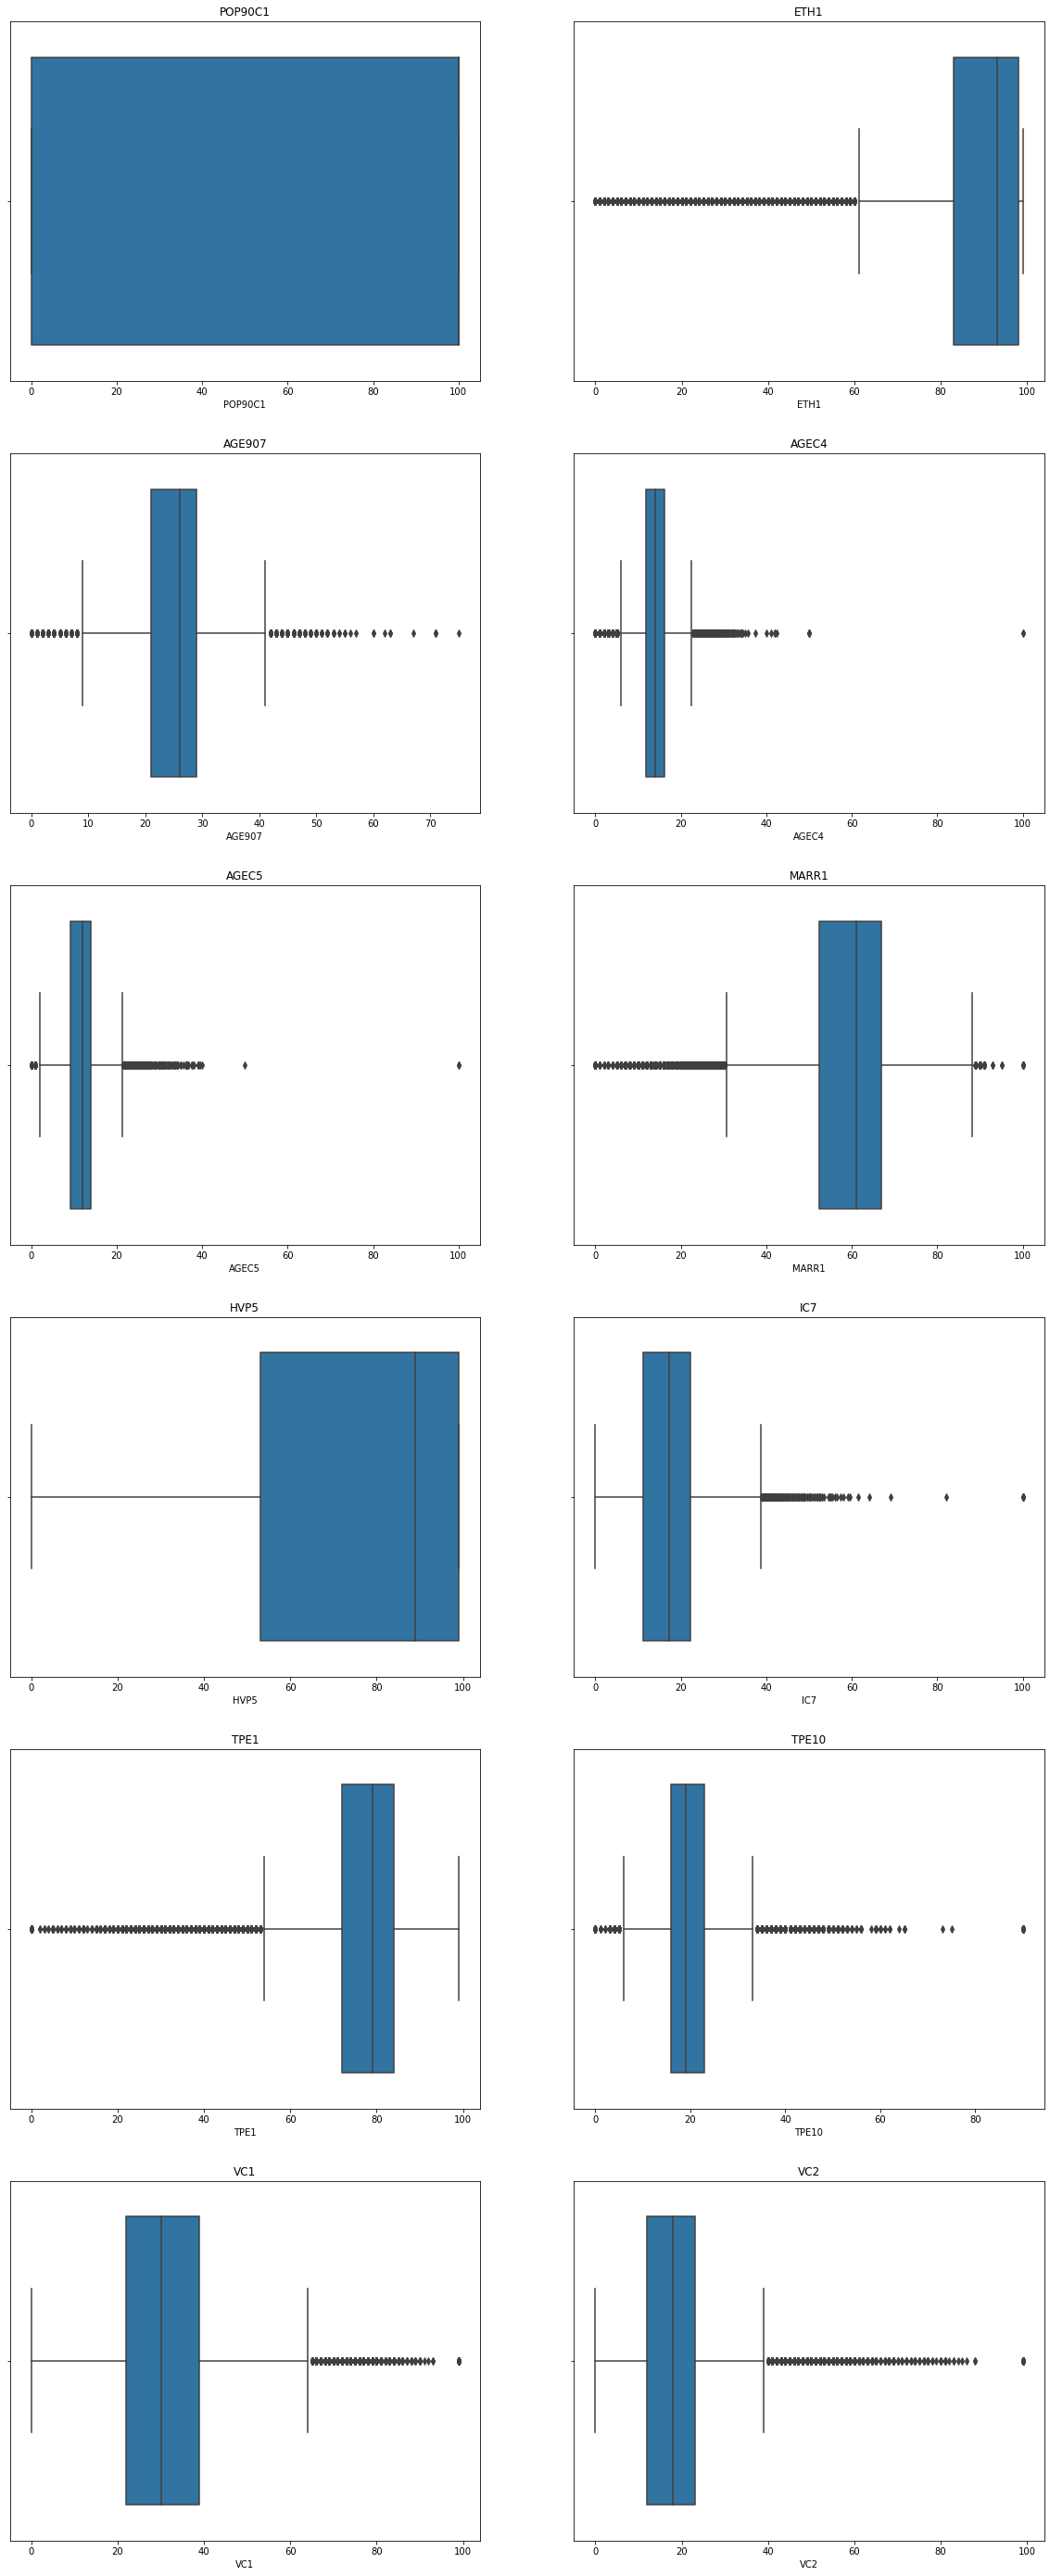

In [20]:
hist_box_plotting( df_fix[selected_percentage] , False)

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E16F7B21F0>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E16F7B21F0>
Setting pcolormesh


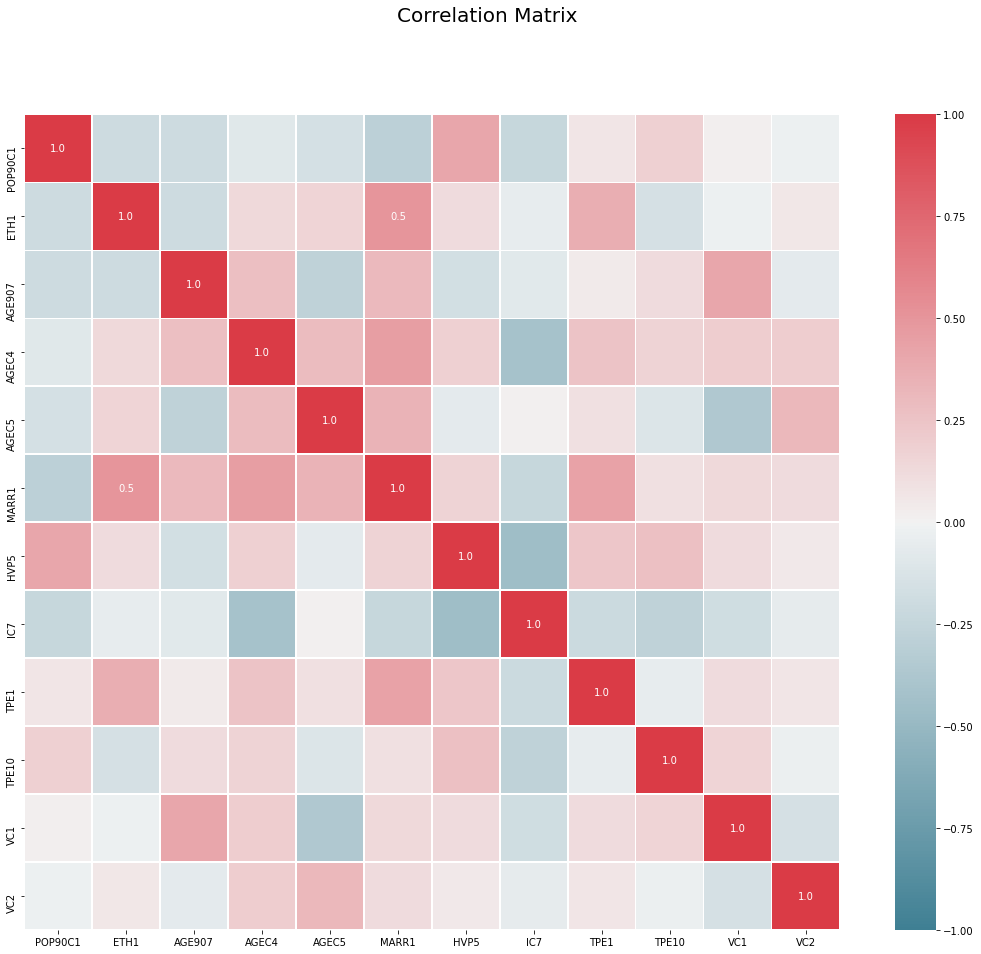

In [21]:
# Checking results:
correlation(df_fix[selected_percentage], 'pearson', 0.5 )

In [22]:
df_fix[selected_percentage]

,POP90C1,ETH1,AGE907,AGEC4,AGEC5,MARR1,HVP5,IC7,TPE1,TPE10,VC1,VC2
0,0.0,92,25,17.171717,13.131313,61.616162,47,23.232323,88,14,34,23
1,100.0,67,32,23.232323,10.101010,69.000000,99,6.000000,80,24,55,10
2,0.0,96,23,16.161616,13.131313,63.000000,50,18.000000,74,19,28,23
3,0.0,61,25,17.000000,12.000000,62.376238,92,12.000000,58,13,14,40
4,100.0,2,27,15.000000,20.000000,41.584158,67,29.292929,73,24,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...
94608,100.0,78,30,15.151515,8.080808,58.000000,92,12.871287,76,18,48,15
94609,96.0,91,39,16.831683,6.930693,73.737374,97,9.000000,80,25,43,5
94610,100.0,82,32,9.090909,9.090909,45.000000,9,26.000000,83,17,46,0
94611,100.0,92,25,18.000000,12.000000,56.000000,99,3.960396,80,18,35,18


Let's bring the description of each feature to divide our clustering into components:

In [23]:
#POP90C1                     Percent Population in Urbanized Area
#ETH1                        Percent White
#AGE907                      Percent Population Under Age 18
#AGEC4                       Percent Adults Age 45-54
#AGEC5                       Percent Adults Age 55-64 (discarded)
#MARR1                       Percent Married
#HVP5                        Percent Home Value >= $50,000
#IC7                         Percent Households w/ Income $15,000 - $24,999

neighborhood_social_economic = ['POP90C1', 'ETH1', 'MARR1', 'AGE907', 'AGEC4', 'HVP5', 'IC7']


#TPE1                        Percent Driving to Work Alone Car/Truck/Van
#TPE10                       Median Travel Time to Work in minutes
#VC1                         Percent Vietnam Veterans Age 16+
#VC2                         Percent Korean Veterans Age 16+

Let's use the social economic status variables only:

In [24]:
df_social_eco = df_fix[neighborhood_social_economic].copy()
df_social_eco.head()

,POP90C1,ETH1,MARR1,AGE907,AGEC4,HVP5,IC7
0,0.0,92,61.616162,25,17.171717,47,23.232323
1,100.0,67,69.000000,32,23.232323,99,6.000000
2,0.0,96,63.000000,23,16.161616,50,18.000000
3,0.0,61,62.376238,25,17.000000,92,12.000000
4,100.0,2,41.584158,27,15.000000,67,29.292929


## Kmeans:

No need of scaling, all the features are in terms of percentages:

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSiz

findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Bold.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Euro Sign' (eurosign.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Caslon Pro' (ACaslonPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<

findfont: score(<Font 'Myriad Pro' (MyriadPro-SemiboldIt.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Adobe Gurmukhi' (AdobeGurmukhi-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kozuka Gothic Pro' (KozGoPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Adobe Hebrew' (AdobeHebrew-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 1

findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Kozuka Mincho Pro' (KozMinPro-Medium.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Charlemagne Std' (CharlemagneStd-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Myriad Arabic' (MyriadArabic-It.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Minion Pro' (MinionPro-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
find

findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
findfont: score(<Font 'Gentium Book Basic' (GenBkBasR.ttf) normal normal book normal>) = 10.05
findfont: score(<Font 'Arimo' (Arimo-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 7.613636363636363
findfont: score(<Font 'Tekton Pro' (TektonPro-BoldCond.otf) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font

findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Nueva Std' (NuevaStd-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Heavy.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
findfont: score(<Font 'Source Sans Pro' (SourceSansPro-Semibold.otf) normal normal semibold normal>) = 10.24
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Informal Roman' (INFROMAN.TTF) normal normal roman normal>) = 10.145
findfont: score(<Font 'Kozuka Gothic Pr6N' (KozGoPr6N-Regular.otf) normal normal

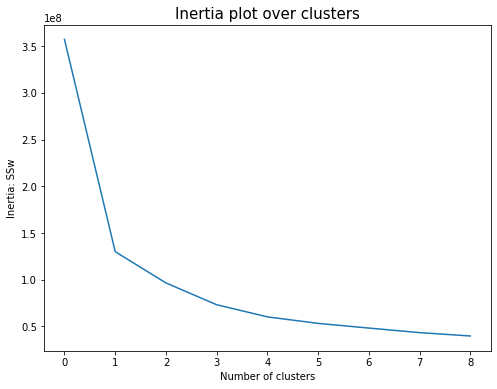

In [25]:
inertia_plot(df_social_eco)

In [93]:
number_clusters = 2
kmclust = KMeans(n_clusters = number_clusters, 
                 init='k-means++', 
                 n_init = 15, 
                 random_state=73)

km_labels = kmclust.fit_predict(df_social_eco)

print(kmclust.inertia_)

df_social_eco_clust = pd.concat((df_social_eco, pd.Series(km_labels, name='kmeans_SE')), axis=1)
df_social_eco_clust.groupby('kmeans_SE').mean()

130017101.93970475


,POP90C1,ETH1,MARR1,AGE907,AGEC4,HVP5,IC7
kmeans_SE,,,,,,,
0,98.046757,82.539935,55.929453,23.614397,13.868303,84.036528,15.481925
1,1.517009,90.152876,62.612007,26.396512,14.640252,60.162645,19.431735


Text(0.5, 0, 'Kmeans Cluster')

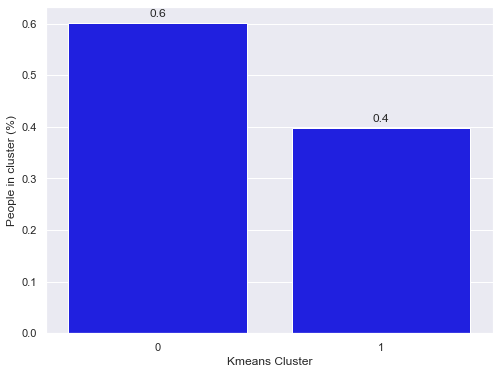

In [94]:
prop_se = df_social_eco_clust.kmeans_SE.value_counts(normalize=True).to_frame()#.bar()#.unstack()

prop_se = prop_se.reset_index()

plt.figure(figsize=(8, 6))
splot = sns.barplot(x="index", y="kmeans_SE", data=prop_se.reset_index() , color = 'blue') #, orient = 'h'

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.ylabel('People in cluster (%)')
plt.xlabel('Kmeans Cluster')

In [95]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_social_eco)  # get total sum of squares (without the column label for kmeans)

ssw_labels = df_social_eco_clust.groupby(by='kmeans_SE').apply(get_ss)  # compute ssw for each cluster labels

ssb = sst - np.sum(ssw_labels)  # SST = SSW + SSB

r2 = ssb / sst
print("Cluster solution kmeans with R^2 of %0.4f" % r2)

Cluster solution kmeans with R^2 of 0.6359


In [29]:
#df_social_eco_clust.kmeans.to_csv('kmeans_labels.csv', index=False)

In [30]:
#df_finalSOM.to_csv('SOM_CLUSTERING_RESULT.csv')

#df_finalSOM.label.to_csv('SOM_CLUSTERING_RESULT(label).csv')

# Clustering historical behaviour:

We will cluster now donating behaviours features:

In [96]:
#CARDGIFT                    Number of lifetime gifts to card promotions to date
#CARDPROM                    Lifetime number of card promotions received to date
#NGIFTALL                    Number of lifetime gifts to date
#NUMPROM                     Lifetime number of promotions received to date

#LASTDATE                    Date associated with the most recent gift

df_donation = df_fix[['CARDGIFT', 'CARDPROM', 'NGIFTALL', 'NUMPROM', 'LASTDATE']].copy()

# Getting date using a parser
month_no_donation = df_donation.LASTDATE.apply(lambda x: parse(x).date())

# Getting the months passed by 2018:
month_no_donation = month_no_donation.apply(lambda X: (parse('01-01-2018').date() - X ).days / 12)

# Inserting the column in a convinient possition
df_donation.insert(loc=0, column='month_no_donation', value=month_no_donation.values)
df_donation.drop(columns='LASTDATE', inplace=True)

df_donation.head()

,month_no_donation,CARDGIFT,CARDPROM,NGIFTALL,NUMPROM
0,63.500000,14,27,31,74
1,63.500000,1,12,3,32
2,63.500000,14,26,27,63
3,63.500000,7,27,16,66
4,60.916667,8,43,37,113


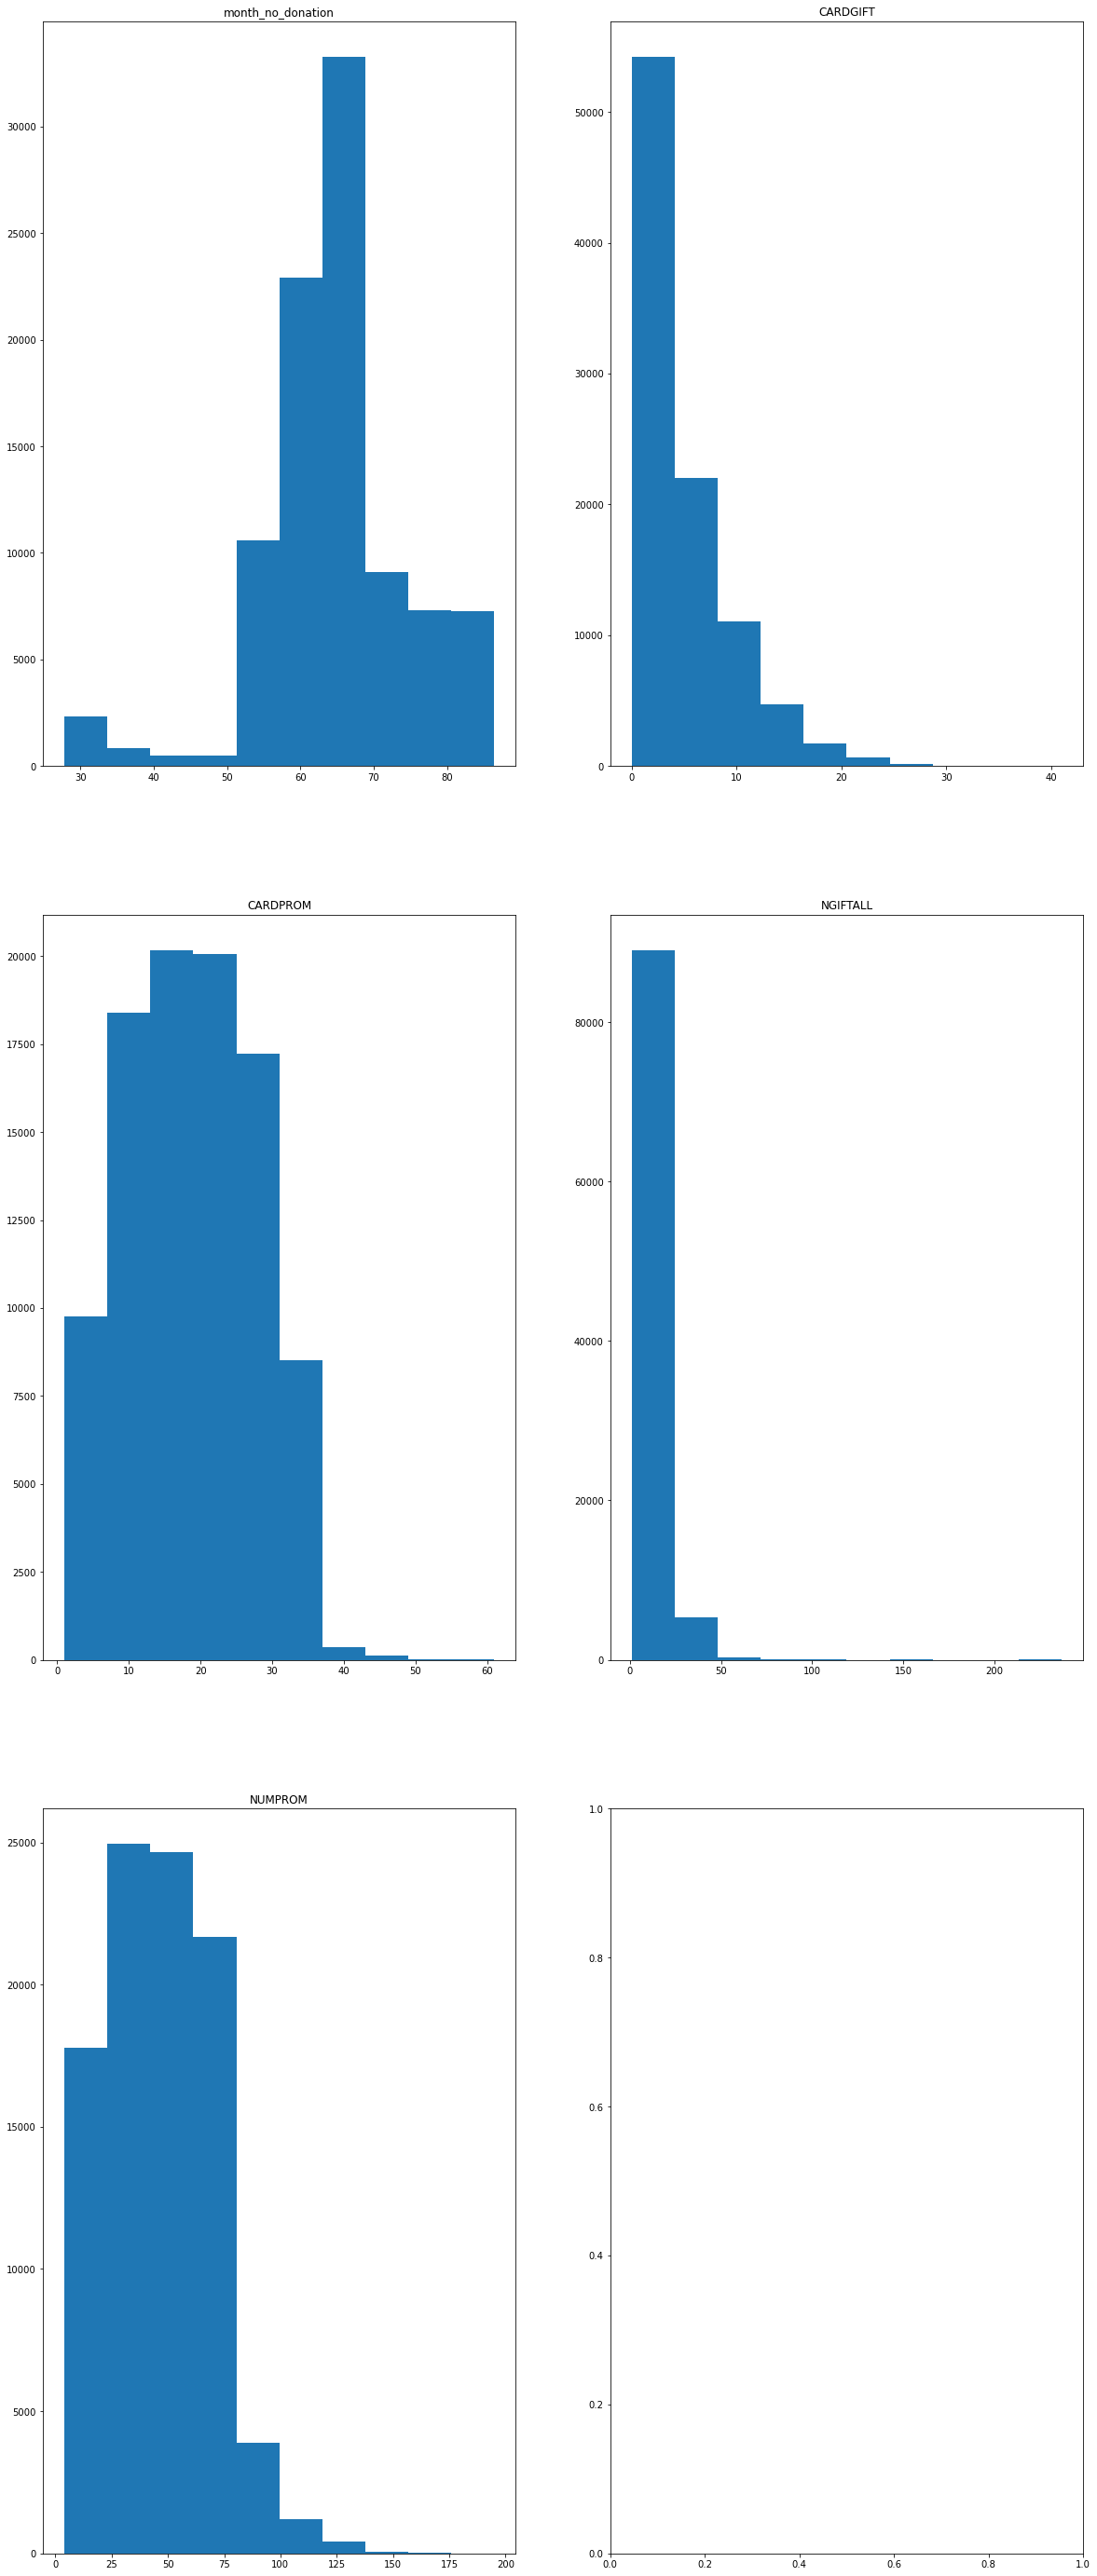

In [32]:
hist_box_plotting( df_donation ) 

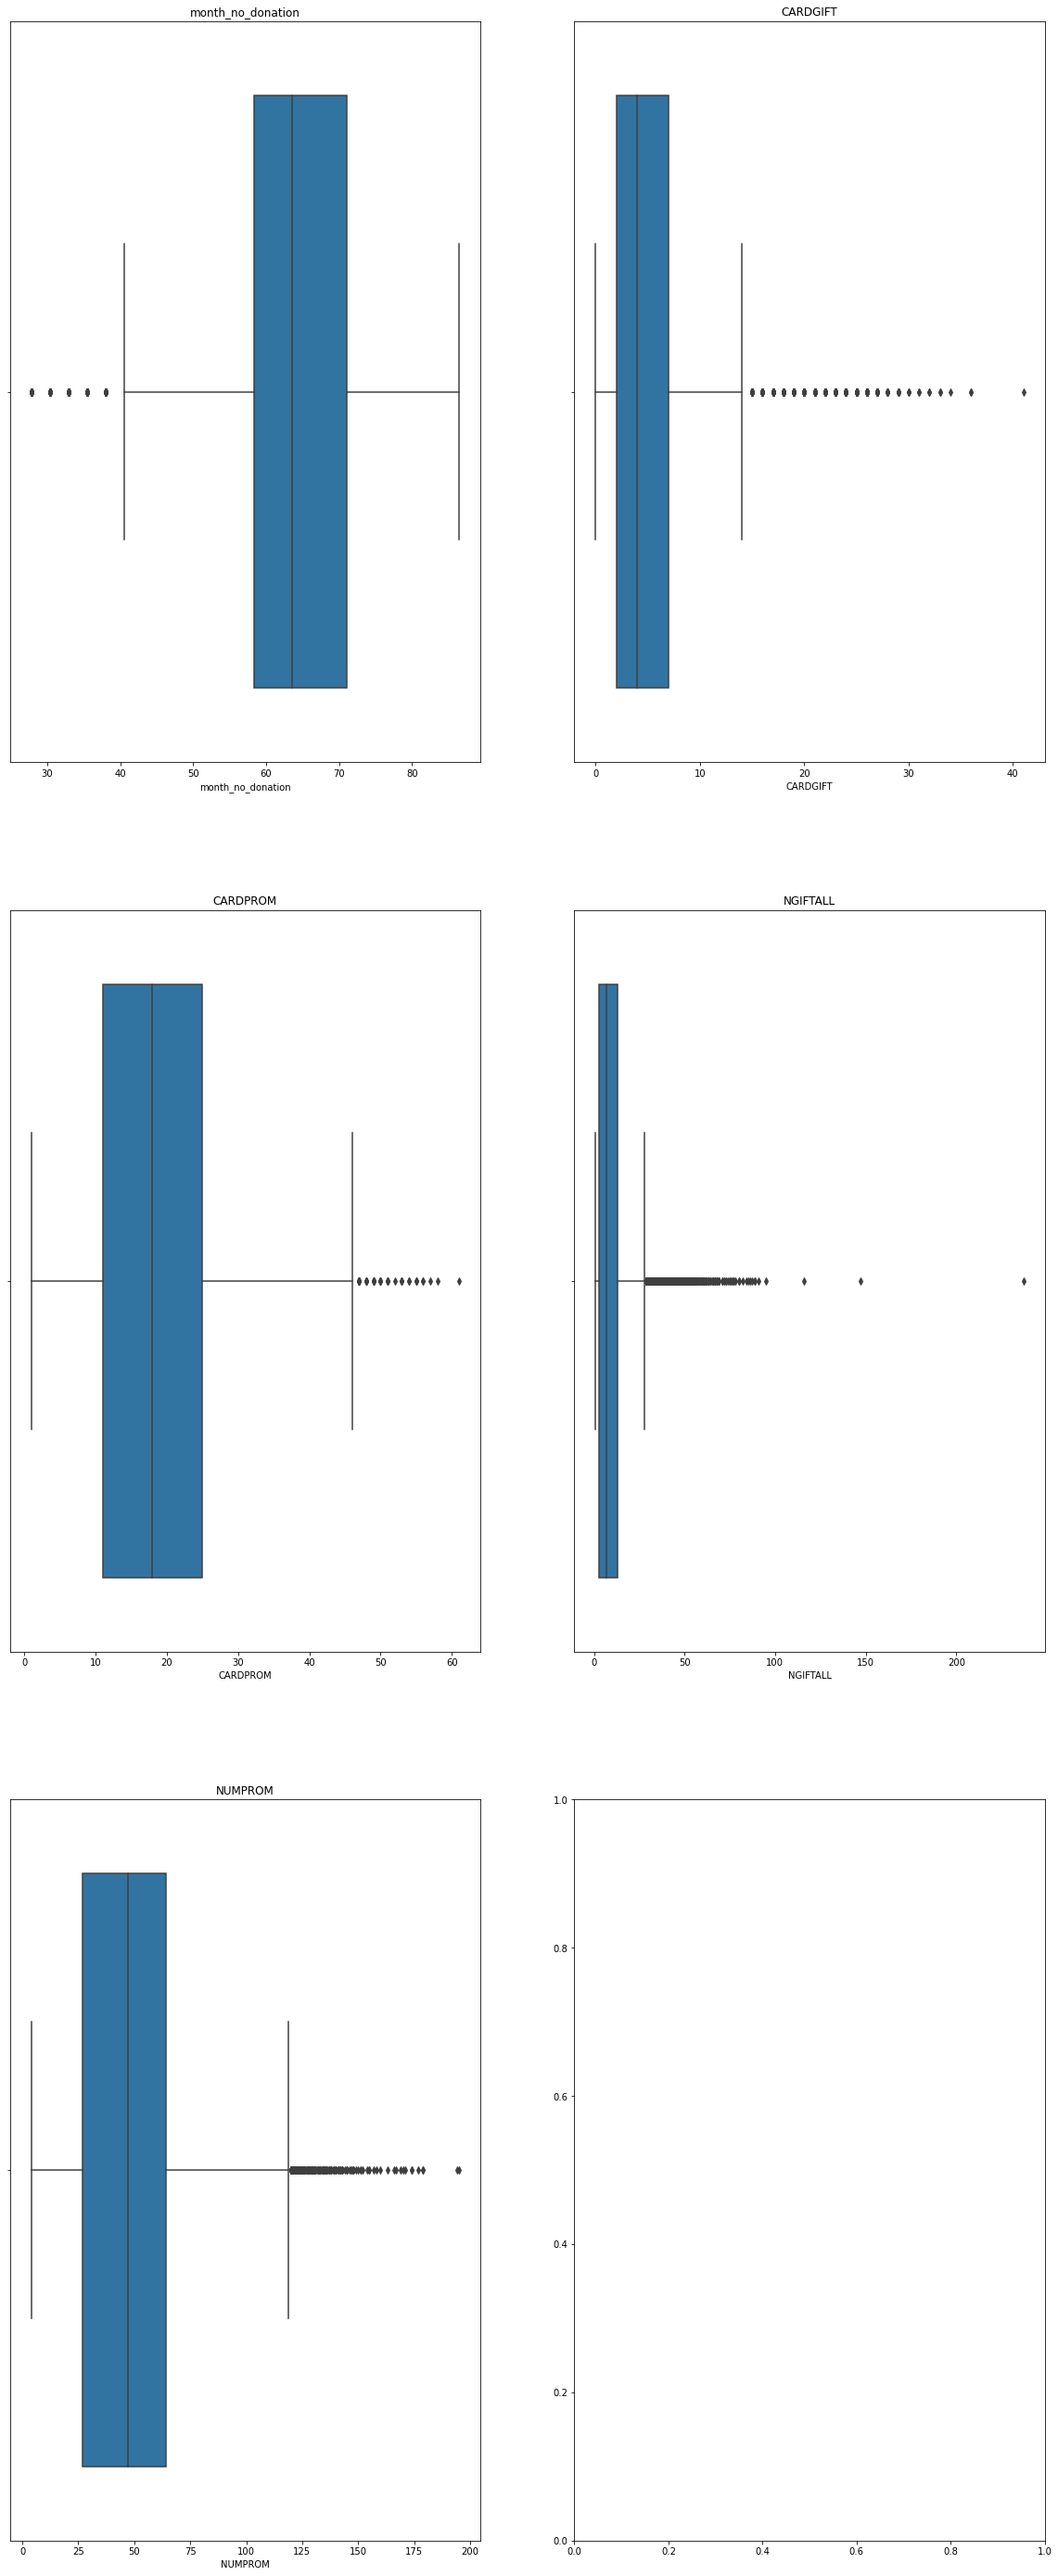

In [33]:
hist_box_plotting( df_donation , False) 

In [34]:
df_donation.corr()

,month_no_donation,CARDGIFT,CARDPROM,NGIFTALL,NUMPROM
month_no_donation,1.000000,-0.090499,-0.062495,-0.149538,-0.140735
CARDGIFT,-0.090499,1.000000,0.779342,0.914544,0.748503
CARDPROM,-0.062495,0.779342,1.000000,0.775834,0.948964
NGIFTALL,-0.149538,0.914544,0.775834,1.000000,0.794515
NUMPROM,-0.140735,0.748503,0.948964,0.794515,1.000000


Having high correlations by the card variables, let's drop those:


In [97]:
df_donation.drop(columns=['CARDGIFT', 'CARDPROM'], inplace=True)

## Kmeans:

Let's plot the inertia  to asses the best number of clusters.

In [98]:
scaler = RobustScaler()

df_donation_scaled = pd.DataFrame(scaler.fit_transform(df_donation), columns=df_donation.columns)

df_donation_scaled 

,month_no_donation,NGIFTALL,NUMPROM
0,0.000000,2.4,0.729730
1,0.000000,-0.4,-0.405405
2,0.000000,2.0,0.432432
3,0.000000,0.9,0.513514
4,-0.202614,3.0,1.783784
...,...,...,...
94608,-0.405229,-0.6,-0.891892
94609,-0.594771,-0.6,-1.000000
94610,-1.993464,0.0,-0.378378
94611,-2.594771,3.4,2.162162


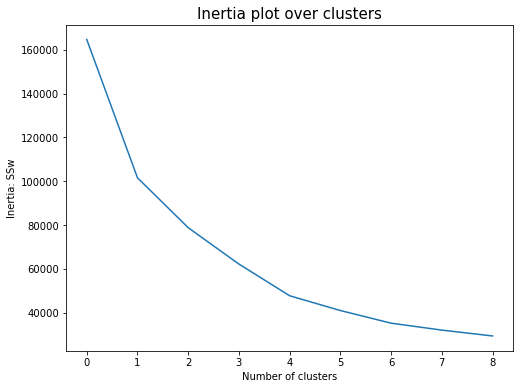

In [37]:
inertia_plot(df_donation_scaled)

In [99]:
number_clusters = 3
kmclust = KMeans(n_clusters = number_clusters, 
                 init='k-means++', 
                 n_init = 15, 
                 random_state=73)

km_labels = kmclust.fit_predict(df_donation_scaled)

print(kmclust.inertia_)

df_donation_clust = pd.concat((df_donation, pd.Series(km_labels, name='kmeans_donation')), axis=1)
df_donation_clust.groupby('kmeans_donation').mean()

78770.32332238289


,month_no_donation,NGIFTALL,NUMPROM
kmeans_donation,,,
0,59.790685,19.654969,72.270078
1,61.461219,4.894013,33.377876
2,77.734368,7.236479,45.266190


Text(0.5, 0, 'Kmeans Cluster')

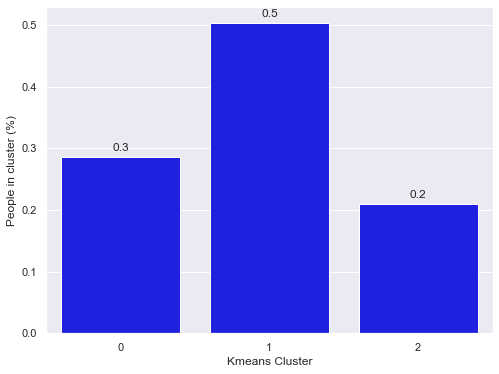

In [100]:
prop_se = df_donation_clust.kmeans_donation.value_counts(normalize=True).to_frame()#.bar()#.unstack()

prop_se = prop_se.reset_index()

plt.figure(figsize=(8, 6))
splot = sns.barplot(x="index", y="kmeans_donation", data=prop_se.reset_index() , color = 'blue') #, orient = 'h'

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.ylabel('People in cluster (%)')
plt.xlabel('Kmeans Cluster')

In [101]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_donation)  # get total sum of squares (without the column label for kmeans)

ssw_labels = df_donation_clust.groupby(by='kmeans_donation').apply(get_ss)  # compute ssw for each cluster labels

ssb = sst - np.sum(ssw_labels)  # SST = SSW + SSB

r2 = ssb / sst
print("Cluster solution kmeans with R^2 of %0.4f" % r2)

Cluster solution kmeans with R^2 of 0.5209


Mergin both dataframes:

In [102]:
df__clust = pd.concat(( df_social_eco_clust , df_donation_clust ), axis=1)

df__clust

,POP90C1,ETH1,MARR1,AGE907,AGEC4,HVP5,IC7,kmeans_SE,month_no_donation,NGIFTALL,NUMPROM,kmeans_donation
0,0.0,92,61.616162,25,17.171717,47,23.232323,1,63.500000,31,74,0
1,100.0,67,69.000000,32,23.232323,99,6.000000,0,63.500000,3,32,1
2,0.0,96,63.000000,23,16.161616,50,18.000000,1,63.500000,27,63,0
3,0.0,61,62.376238,25,17.000000,92,12.000000,1,63.500000,16,66,0
4,100.0,2,41.584158,27,15.000000,67,29.292929,0,60.916667,37,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...
94608,100.0,78,58.000000,30,15.151515,92,12.871287,0,58.333333,1,14,1
94609,96.0,91,73.737374,39,16.831683,97,9.000000,0,55.916667,1,10,1
94610,100.0,82,45.000000,32,9.090909,9,26.000000,0,38.083333,7,33,1
94611,100.0,92,56.000000,25,18.000000,99,3.960396,0,30.416667,41,127,0


Let's look at the centroids for each pair of clusters:

In [103]:
df__clust.groupby(by = ['kmeans_donation', 'kmeans_SE']).mean()

POP90C1       ETH1      MARR1     AGE907  \
kmeans_donation kmeans_SE                                               
0               0          98.083954  84.369999  55.865107  23.077545   
                1           1.271631  91.009980  62.424677  26.090328   
1               0          98.044285  81.634513  55.828428  23.794373   
                1           1.647698  89.644880  62.636957  26.568619   
2               0          98.005810  82.421901  56.255069  23.856215   
                1           1.580873  90.051989  62.838269  26.454770   

                               AGEC4       HVP5        IC7  month_no_donation  \
kmeans_donation kmeans_SE                                                       
0               0          13.619365  83.037208  15.977040          59.494613   
                1          14.447843  57.691999  19.814330          60.178224   
1               0          13.927295  84.287816  15.361559          61.409968   
                1          14.709249  61.229661  19.276207          61.543860   
2               0          14.039626  84.689247  15.148530          77.740868   
                1          14.769754  61.396023  19.217713          77.724092   

                            NGIFTALL    NUMPROM  
kmeans_donation kmeans_SE                        
0               0          19.541249  72.495830  
                1          19.803821  71.974582  
1               0           4.819108  33.188434  
                1           5.014792  33.683340  
2               0           7.086074  44.821687  
                1           7.474266  45.968937

Now, in terms of percentages, below we can see how much data we have falling into each cluster:

In [104]:
df_per_clust = (df__clust.groupby(by = ['kmeans_donation', 'kmeans_SE']).count().IC7 * 100 / len(df_fix)).to_frame()

df_per_clust

IC7
kmeans_donation kmeans_SE           
0               0          16.219758
                1          12.391532
1               0          31.107776
                1          19.292275
2               0          12.856584
                1           8.132075

In [45]:
#df__clust.to_csv('cluster_results.csv')

Let's do a manual merge of the cluster and see the R2 results, for that, let's define a helper function:

In [144]:
def merging_clusters(df):    
    for i in range(len(df)):
        
        if df['kmeans_SE'][i]==0:
            if (df['kmeans_donation'][i]==0):
                df['label'][i]=0

        if (df['kmeans_SE'][i]==0):
            if (df['kmeans_donation'][i]==1):
                df['label'][i]=1
                
        if (df['kmeans_SE'][i]==0):
            if (df['kmeans_donation'][i]==2):
                df['label'][i]=2
                
        if(df['kmeans_SE'][i]==1):
            if (df['kmeans_donation'][i]==0):
                df['label'][i]=3
                
        if (df['kmeans_SE'][i]==1):
            if (df['kmeans_donation'][i]==1):
                df['label'][i]=4
            
        if (df['kmeans_SE'][i]==0):
            if (df['kmeans_donation'][i]==2):
                df['label'][i]=5

In [145]:
df__clust_manual = df__clust.copy()
df__clust_manual['label'] = 0
merging_clusters(df__clust_manual)

df__clust_manual.head()

,POP90C1,ETH1,MARR1,AGE907,AGEC4,HVP5,IC7,kmeans_SE,month_no_donation,NGIFTALL,NUMPROM,kmeans_donation,label
0,0.0,92,61.616162,25,17.171717,47,23.232323,1,63.500000,31,74,0,3
1,100.0,67,69.000000,32,23.232323,99,6.000000,0,63.500000,3,32,1,1
2,0.0,96,63.000000,23,16.161616,50,18.000000,1,63.500000,27,63,0,3
3,0.0,61,62.376238,25,17.000000,92,12.000000,1,63.500000,16,66,0,3
4,100.0,2,41.584158,27,15.000000,67,29.292929,0,60.916667,37,113,0,0


In [147]:
# Computing the R^2 of the cluster solution
sst = get_ss(df__clust_manual[metric_f])  # get total sum of squares (without the column label for kmeans)

ssw_labels = df__clust_manual[metric_f + ['label']].groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels

ssb = sst - np.sum(ssw_labels)  # SST = SSW + SSB

r2 = ssb / sst
print("Cluster solution kmeans with R^2 of %0.4f" % r2)

Cluster solution kmeans with R^2 of 0.5068


Since our R2 is low, we're going to proceed with the merge of our clustering solution using Hierarchical Clustering.

## Merging the clusters:

In [105]:
df_centroids = df__clust.groupby(by = ['kmeans_donation', 'kmeans_SE']).mean()

In [106]:
# Defining metric features
metric_f = df__clust.columns.to_list()

# Removing the clusters
metric_f.remove('kmeans_donation')
metric_f.remove('kmeans_SE')

In [114]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

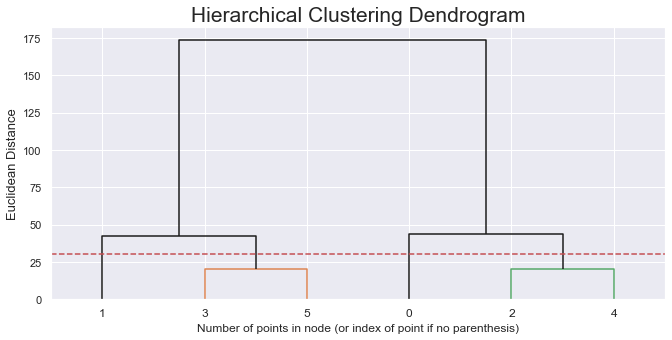

In [115]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [111]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

POP90C1       ETH1      MARR1     AGE907  \
kmeans_donation kmeans_SE                                               
0               0          98.083954  84.369999  55.865107  23.077545   
                1           1.271631  91.009980  62.424677  26.090328   
1               0          98.044285  81.634513  55.828428  23.794373   
                1           1.647698  89.644880  62.636957  26.568619   
2               0          98.005810  82.421901  56.255069  23.856215   
                1           1.580873  90.051989  62.838269  26.454770   

                               AGEC4       HVP5        IC7  month_no_donation  \
kmeans_donation kmeans_SE                                                       
0               0          13.619365  83.037208  15.977040          59.494613   
                1          14.447843  57.691999  19.814330          60.178224   
1               0          13.927295  84.287816  15.361559          61.409968   
                1          14.709249  61.229661  19.276207          61.543860   
2               0          14.039626  84.689247  15.148530          77.740868   
                1          14.769754  61.396023  19.217713          77.724092   

                            NGIFTALL    NUMPROM  hclust_labels  
kmeans_donation kmeans_SE                                       
0               0          19.541249  72.495830              2  
                1          19.803821  71.974582              3  
1               0           4.819108  33.188434              1  
                1           5.014792  33.683340              0  
2               0           7.086074  44.821687              1  
                1           7.474266  45.968937              0

Let's get the centroids for the new merged clustering solution:

In [112]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df__clust_merged = df__clust.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df__clust_merged['merged_labels'] = df__clust_merged.apply(
    lambda row: cluster_mapper[
        (row['kmeans_donation'], row['kmeans_SE'])
    ], axis=1
)

# Merged cluster centroids
df__clust_merged.groupby('merged_labels').mean()[metric_f]

,POP90C1,ETH1,MARR1,AGE907,AGEC4,HVP5,IC7,month_no_donation,NGIFTALL,NUMPROM
merged_labels,,,,,,,,,,
0,1.627882,89.765599,62.696651,26.534860,14.727191,61.278992,19.258862,66.341745,5.744094,37.326358
1,98.033034,81.864771,55.953192,23.812458,13.960144,84.405207,15.299263,66.185645,5.482042,36.590369
2,98.083954,84.369999,55.865107,23.077545,13.619365,83.037208,15.977040,59.494613,19.541249,72.495830
3,1.271631,91.009980,62.424677,26.090328,14.447843,57.691999,19.814330,60.178224,19.803821,71.974582


### Assessing R2:

In [131]:
# Computing the R^2 of the cluster solution
sst = get_ss(df__clust_merged[metric_f])  # get total sum of squares (without the column label for kmeans)

ssw_labels = df__clust_merged[metric_f + ['merged_labels']].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels

ssb = sst - np.sum(ssw_labels)  # SST = SSW + SSB

r2 = ssb / sst
print("Cluster solution kmeans with R^2 of %0.4f" % r2)

Cluster solution kmeans with R^2 of 0.6325


#### Assessing by using TSNE:

In [149]:
two_dim = TSNE(random_state=42).fit_transform(df__clust_merged[metric_f])

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E1715857F0>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002E1715857F0>
Setting pcolormesh


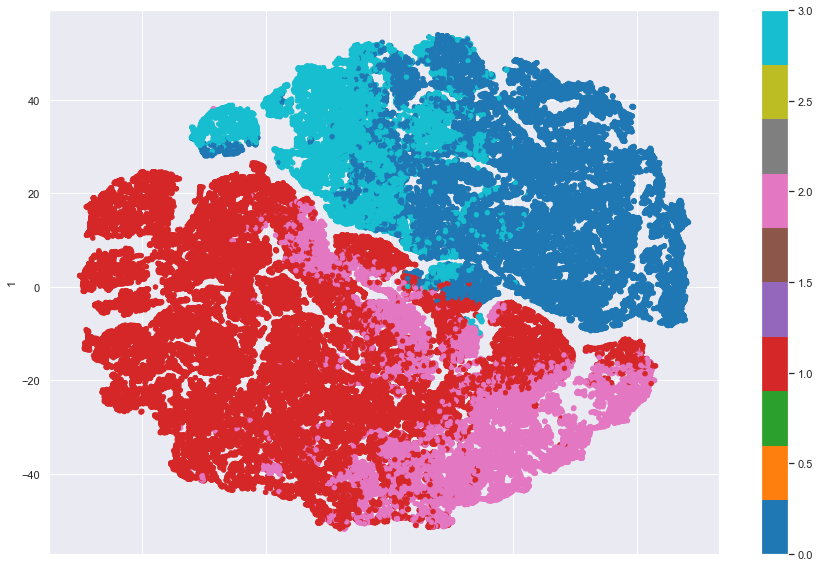

In [150]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df__clust_merged['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [152]:
#df__clust_merged.to_csv('Final_Clustering_Solution.csv', index = False)

In [154]:
#df__clust_merged.merged_labels.to_csv('Final_Clustering_Solution(only_labels).csv', index = False)